Loading dataset...
done!
Building dictionay for input and output ...
done
Training ...


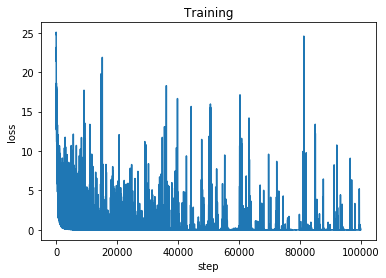

Validation ...
101950______ -> 1950-10-19
1.10.1958___ -> 1958-10-01
JUN 08 60___ -> 1960-06-08
2001.09.20__ -> 2001-09-20
11/29/1986__ -> 1986-11-29
01.05.1984__ -> 1984-05-01
5/29/2004___ -> 2004-05-29
MAY 30, 86__ -> 1986-05-30
17 JUL 1979_ -> 1979-07-17
MAY 22, 68__ -> 1968-05-22
02SEP2036___ -> 2036-09-02
2029.08.31__ -> 2029-08-31
2037-02-09__ -> 2037-02-09
1960.08.05__ -> 1960-08-05
04/01/2029__ -> 2029-04-01
7/28/1951___ -> 1951-07-28
2010.2.19___ -> 2010-02-19
20360518____ -> 2036-05-18
NOV 04 2015_ -> 2015-11-04
4/19/1956___ -> 1956-04-19
MAR 02, 93__ -> 1993-03-02
013088______ -> 1988-01-30
2013-2-4____ -> 2013-02-04
9/25/12_____ -> 2012-09-25
MAY 23, 2010 -> 2010-05-23
DEC 05 68___ -> 1968-12-05
27MAR2047___ -> 2047-03-27
19 MAR 2038_ -> 2038-03-19
APR 30, 38__ -> 2038-04-30
12/25/89____ -> 1989-12-25
MAY 12 09___ -> 2009-05-12
02/25/50____ -> 1950-02-25
JUL 26, 93__ -> 1993-07-26
20 JUN 2043_ -> 2043-06-20
SEP 24, 22__ -> 2022-09-24
FEB 26, 68__ -> 1968-02-26
6/13/1982___ 

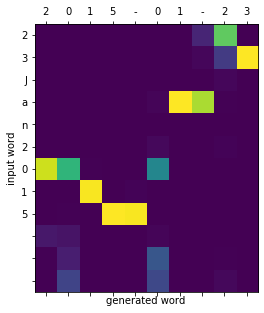

012315 -> 2015-01-23


Attention matrix


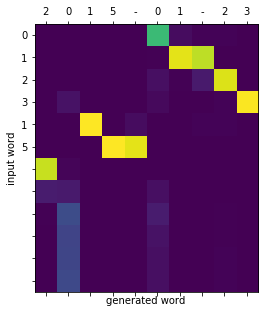

01/23/15 -> 2015-01-23


Attention matrix


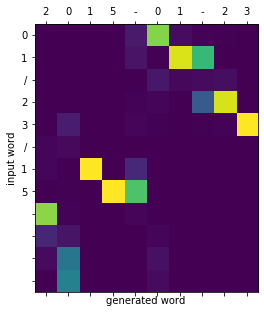

1/23/15 -> 2015-01-23


Attention matrix


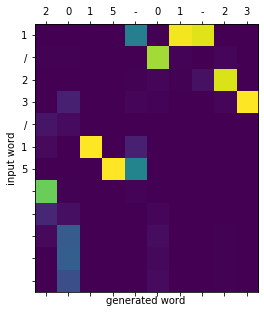

01/23/2015 -> 2015-01-23


Attention matrix


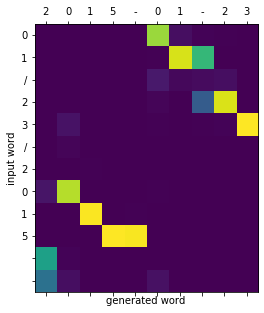

1/23/2015 -> 2015-01-23


Attention matrix


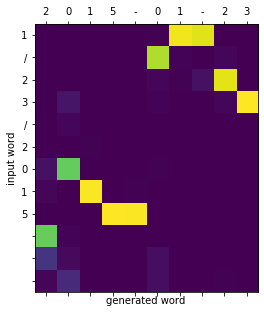

23-01-2015 -> 2015-01-23


Attention matrix


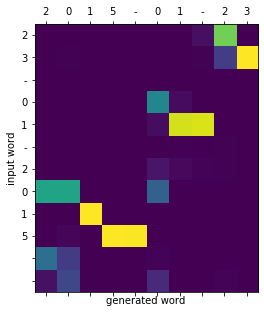

23-1-2015 -> 2015-01-23


Attention matrix


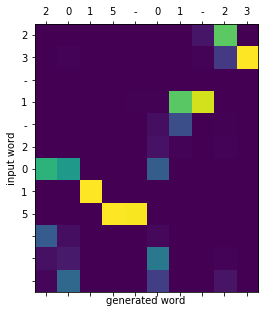

JAN 23, 15 -> 2015-01-23


Attention matrix


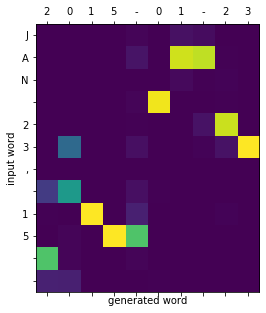

Jan 23, 2015 -> 2015-01-23


Attention matrix


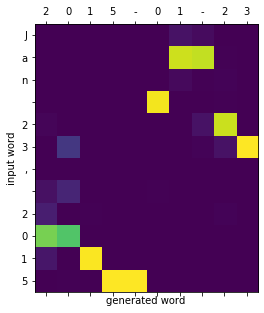

23.01.2015 -> 2015-01-23


Attention matrix


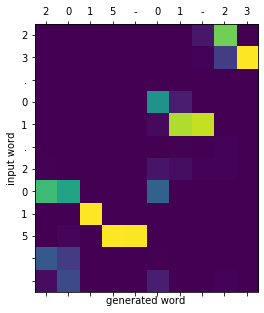

23.1.2015 -> 2015-01-23


Attention matrix


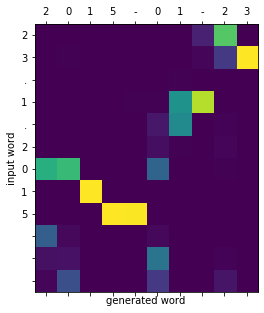

2015.01.23 -> 2015-01-23


Attention matrix


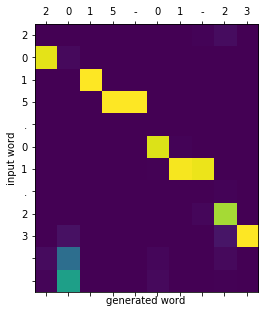

2015.1.23 -> 2015-01-23


Attention matrix


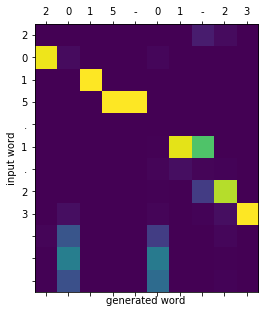

20150123 -> 2015-01-23


Attention matrix


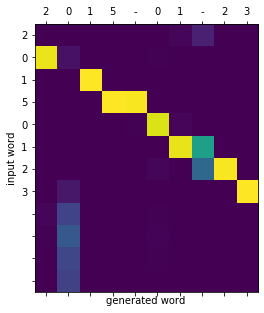

2015/01/23 -> 2015-02-01


Attention matrix


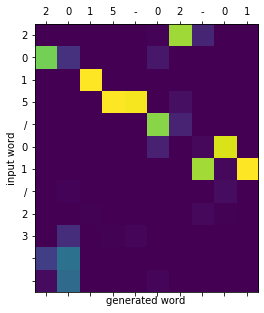

2015-01-23 -> 2015-01-23


Attention matrix


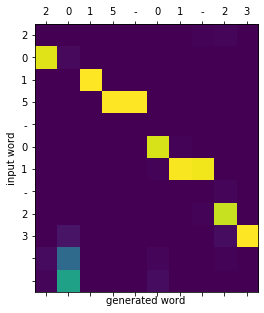

2015-1-23 -> 2015-01-23


Attention matrix


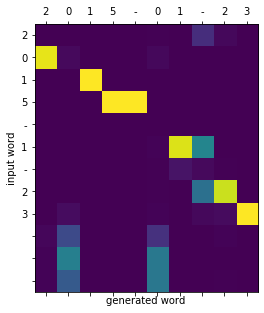

In [2]:
""" 
Example for date conversion
"""
__author__ = "AL-Tam Faroq"
__copyright__ = "Copyright 2020, UALG"
__credits__ = ["Faroq AL-Tam"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Faroq AL-Tam"
__email__ = "ftam@ualg.pt"
__status__ = "Production"

import sys
sys.path.append("..")



# local files
from seq2seq_with_deep_attention.helpers import DateDataset, get_sequence_from_indexes
from seq2seq_with_deep_attention.Luong import LuongGlobalAttention

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # to do train-validate spilit

# plot
import matplotlib.pyplot as plt

# utilis
import random
import math



random_seed = torch.manual_seed(45)

# constants
INPUT_SIZE = 12
OUTPUT_SIZE = 10
HIDDEN_SIZE = 64
BATCH_SIZE = 1
SOS_SYMBOL = '\t' # start of sequence symbol
EOS_SYMBOL= '\n'
PADDING_SYMOBL = '_'
VALIDATION_RATIO = .1



def plot_attention(attention, input_word, generated_word):
    print('\nAttention matrix')
    # plot last attention
    plt.matshow(attention)
    plt.xlabel('generated word')
    plt.xticks(range(10),generated_word)
    plt.ylabel('input word')
    plt.yticks(range(12),input_word)
    plt.show(block=False)



def main():

    ds = DateDataset('/home/faroq/code/seq2seq/out.json', 
                     get_index=True,
                     sequence_length=INPUT_SIZE,
                     SOS_SYMBOL=SOS_SYMBOL,
                     PADDING_SYMBOL=PADDING_SYMOBL)
    
    # train-validate spilit
    ds_len = len(ds)
    indexes = list(range(ds_len))
    random.shuffle(indexes) # shuffle them
    spilit_spot = int(math.floor(VALIDATION_RATIO * ds_len))
    
    train_indexes = indexes[spilit_spot:]
    validation_indexes = indexes[:spilit_spot]

    # samples 
    train_sampler = SubsetRandomSampler(train_indexes)
    validation_sampler = SubsetRandomSampler(validation_indexes)

    # loaders

    train_dataloader = DataLoader(ds,
                            sampler=train_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)

    validation_dataloader = DataLoader(ds,
                            sampler=validation_sampler,
                            batch_size=BATCH_SIZE,
                            num_workers=0)
    


    # Loung Model
    loung = LuongGlobalAttention(input_num_embeddings=len(ds.input_vocab),
                                 output_num_embeddings=len(ds.output_vocab),
                                 hidden_size=HIDDEN_SIZE,
                                 output_size=len(ds.output_vocab),
                                 batch_size=BATCH_SIZE,
                                 sos_symbol_index=ds.input_word_to_index[SOS_SYMBOL],
                                 padding_symbol_index=ds.input_word_to_index[PADDING_SYMOBL],
                                 device='gpu')

    
    # loss function and optimizer
    loss_function = nn.NLLLoss()
    opitmizer = optim.Adam(loung.parameters(), lr=0.001)


    ################## Training #############
    print('Training ...')
    losses = []
    samples = []
    train_for = 100000 # if we wish to train faster for limited number of batches
    for batch, target_seq, target_seq_shifted in train_dataloader:
        if train_for == 0:
            break
        train_for -= 1
        # put them in the same device as the model's
        target_seq_shifted = target_seq_shifted.to(loung.device)
        target_seq = target_seq.to(loung.device)
        # train a Loung seq2seq model
        loung.zero_grad()
        loung.encoder.zero_grad()
        loung.decoder.zero_grad()
        output_seq_probs, output_seq, hidden, attention, context = loung(batch, target_seq_shifted)
        loss = 0
        for i in range(OUTPUT_SIZE):
            loss += loss_function(output_seq_probs[:, i, :], target_seq[:, i])
        loss.backward()
        opitmizer.step()
        losses.append(loss.detach().cpu().item())
        # uncomment this line to check how store all training tuples
        #samples.append((target_seq.detach().cpu().numpy(), output_seq.detach().cpu().numpy()))  

    # plot loss
    plt.figure()
    plt.title("Training")
    plt.plot(losses)
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.show(block=False)


################################ Validation #############################
    
    print('Validation ...')
    validate_for = 100 # to see the results fast
    for batch, target_seq, target_seq_shifted in validation_dataloader:
        if validate_for == 0:
            break
        validate_for -= 1
        # ignore the last batch if it does not fit the expected batch size
        if batch.size()[0] < BATCH_SIZE:
            break
        target_seq_shifted = target_seq_shifted.to(loung.device)
        output_seq_probs, output_seq, hidden, attention, context = loung(batch, target_seq_shifted)

        # to get the best perfomace increase the batch size above and uncomment all the following lines
        input_word = get_sequence_from_indexes(ds.input_word_to_index, batch.detach().cpu().numpy())
        target_word = get_sequence_from_indexes(ds.output_word_to_index, target_seq.detach().cpu().numpy())
        generated_word = get_sequence_from_indexes(ds.output_word_to_index, output_seq.detach().cpu().numpy())
        samples.append((''.join(input_word), ''.join(target_word), ''.join(generated_word)))  
    
    
    with open('validation_results.txt', 'w') as f:
        for x in samples:
            f.write('%s\t%s\t(%s)\n' % x)
            print('%s -> %s' % (x[0], x[2]))
    

################################ Testing ############################
    # we need to run loung model for each symbol, 
    print('\n\nTesting ....')
    input_list = ['23Jan2015', '012315', '01/23/15', '1/23/15', '01/23/2015', '1/23/2015', '23-01-2015', '23-1-2015', 'JAN 23, 15', 'Jan 23, 2015', '23.01.2015', '23.1.2015', '2015.01.23', '2015.1.23', '20150123', '2015/01/23', '2015-01-23', '2015-1-23']

    for x in input_list:
        input_seq = ds.input_sequence_to_index(x.upper())
        #print(x, input_seq)
        input_seq = input_seq.to(loung.device)
        target_seq_shifted = torch.tensor(ds.output_word_to_index[SOS_SYMBOL])
        input_seq = input_seq.unsqueeze(0) # make it in the proper dimension - 3D
        target_seq_shifted = target_seq_shifted.unsqueeze(0).unsqueeze(0).to(loung.device)
        for _ in range(OUTPUT_SIZE):
            output_seq_probs, output_seq, hidden, attention, context = loung(input_seq, target_seq_shifted)
            target_seq_shifted = torch.cat((target_seq_shifted[0], output_seq[:,-1])).unsqueeze(0)
        
        generated_word = get_sequence_from_indexes(ds.output_word_to_index, target_seq_shifted.detach().cpu().numpy())
        generated_word = ''.join(generated_word[1:]) # ingnore the SOS symbol
        print('%s -> %s\n' % (x, generated_word))
        plot_attention(attention[0].t().detach().cpu(), x, generated_word)







if __name__ is '__main__':
    main()
